In [3]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [4]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Nearest Neighbor

In [5]:
class KNearest_Neighbor:
    
    def __init__(self,x_train, y_train,x_test,y_test, k = 10):
        
        self.k = k
        
        # init data as global
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])   
    
    def MAE(self, y_pred, y_test):
        return (np.mean(np.abs(y_pred-y_test)))
    
    def fit(self, x_train, y_train):
        
        # compute euclidean distance matrix
        a = np.einsum('ij, ij ->i', self.x_test, self.x_test)[:, None]
        b = np.einsum('ij, ij ->i', x_train, x_train)
        c = 2 * self.x_test.dot(x_train.T)
        
        self.dist = a + b - c
    
    def predict(self, x_test):
    
        # calc mean of distances, y_pred
        y_pred = np.mean(self.y_train[np.argsort(self.dist)[:,:self.k]], axis = 1)
        
        MSE = self.MSE(y_pred,self.y_test)
        
        return y_pred, MSE

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

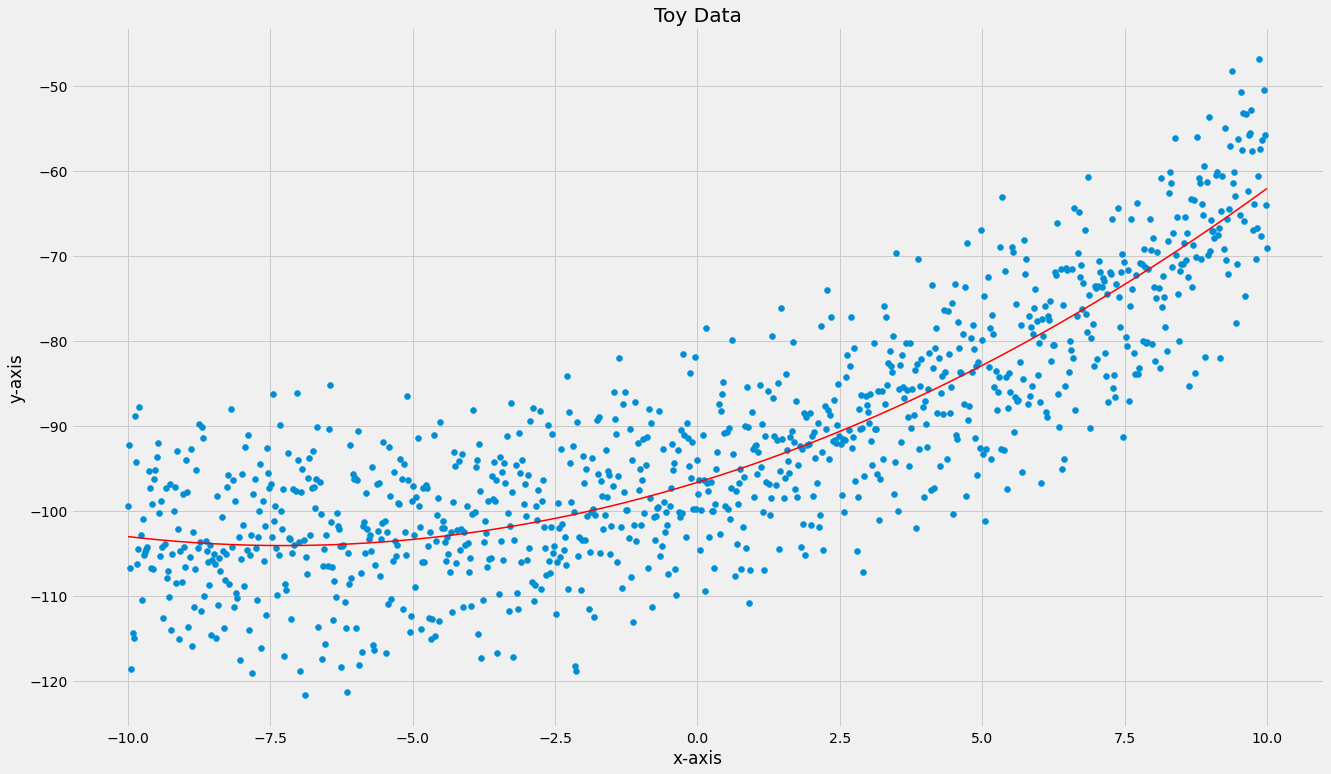

In [6]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    y_actual = []
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
            y_actual.append(a*x[i] + b)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            y_actual.append(a*x[i]**exp + b*x[i] + c)
            
    return x, y, y_actual
    
x, y, y_actual = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.plot(x,y_actual, c = 'r', linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [7]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

# convert data to array for model fitting
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [8]:
# create KNN class
KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 10)

# fit model to training data
KNN.fit(x_train,y_train)

# predict from test data
y_pred, MSE= KNN.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.14821341619713155


In [9]:
# unnormalize data
x_test, y_test = unnormalize(x_test, test[1]['x'], test[2]['x']), unnormalize(y_test, test[1]['y'],  test[2]['y'])
y_pred = unnormalize(y_pred, test[1]['y'],  test[2]['y'])

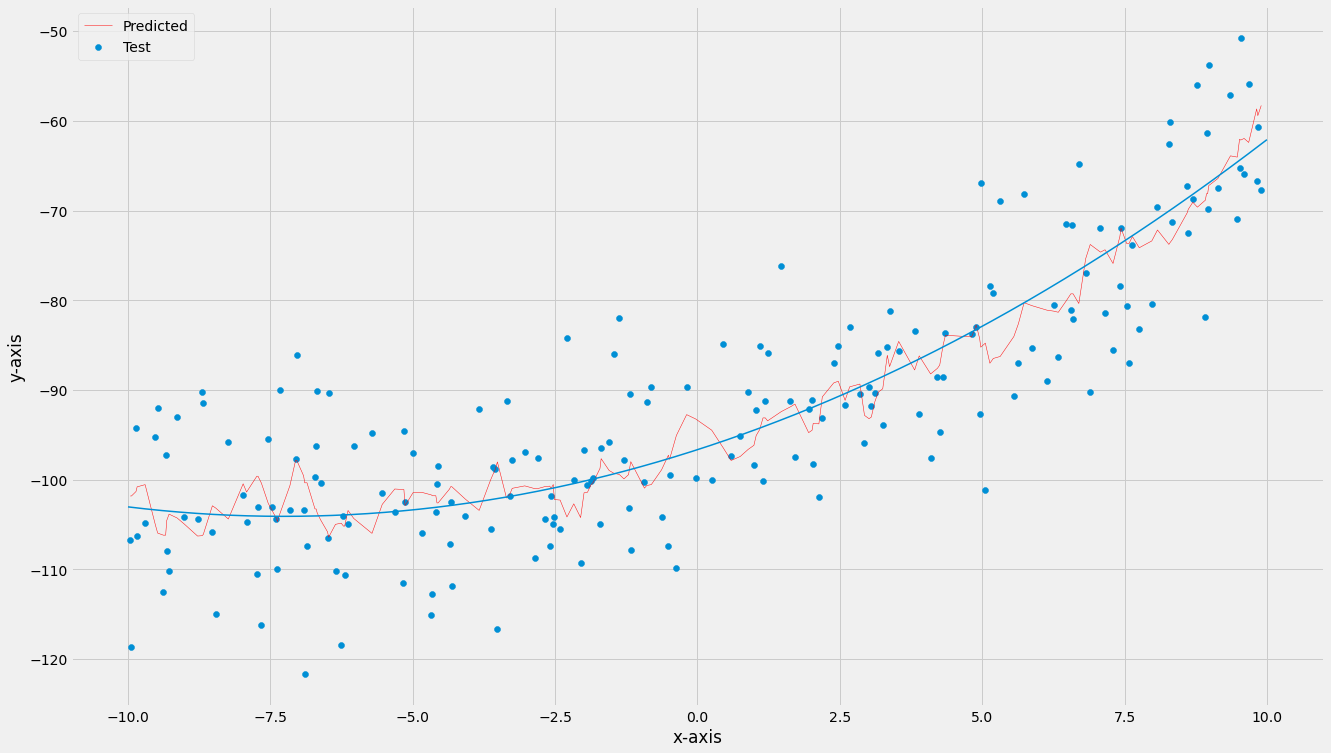

In [10]:
# plot toy data and model prediction

df_pred = pd.DataFrame(x_test, columns = ['x_test'])
df_pred['y_test'] = y_test
df_pred['y_pred'] = y_pred

df_pred.sort_values(by = ['x_test'], inplace = True)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 0.5,
            alpha = 0.95,
         label = 'Predicted')
plt.plot(x,y_actual, linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

In [9]:
def normalize_yield(df):
    # normalize with average of each year
    adjusted_yield = []
    for i in range(1983,2014):
        adjusted_yield.extend((df[df['year'] == i]['yield'] /df[df['year'] == i]['yield'].mean()))

    df['adjusted_yield'] = adjusted_yield
    df = df.drop(['yield'], axis = 1)
    return df

def unnormalize_yield(df_pred,y_test, df):
    y_pred_new = []
    y_test_new = []
    for i in range(1983,2014):
        y_pred_new.extend(df_pred[df_pred.index == i]['y_pred'] * df[df['year'] == i]['yield'].mean())
        y_test_new.extend(y_test[i])
    return y_pred_new, y_test_new

# Import and process data

In [96]:
df_orig = pd.read_csv('maize_major_yield/maize_major_yield.csv')

#df = normalize_yield(df_orig)
#df = df_orig.drop(['year'], axis = 1)
#df.set_index('year', inplace = True)
#df = df.drop(['yield'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
y_year = y_test.index

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Run Model to Predict Crop Yield

In [97]:
# instantiate KNN
KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 
                                                   k = 1)
# fit model to training data
KNN.fit(x_train,y_train)

# predict test data using model
y_pred, MSE= KNN.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.22531096815622975


In [98]:
# unnormalize
y_test = unnormalize(test[0].iloc[:,-1], test[1][-1], test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

In [99]:
KNN.MSE(np.array(y_pred), np.array(y_test))

3.1770434128848457

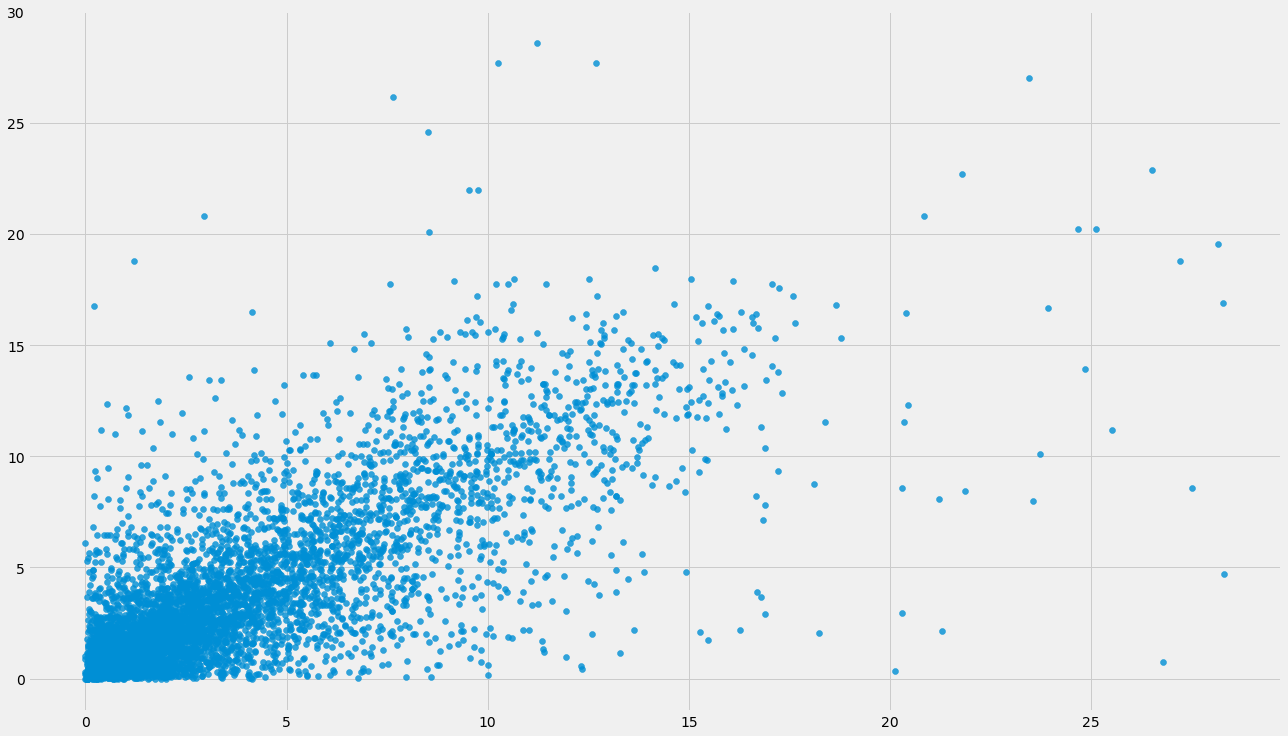

In [100]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'], alpha = 0.8)

In [101]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.773209
y_pred,0.773209,1.000000


In [112]:
# fresh reload of data for hyperparameter optimization

df_orig = pd.read_csv('maize_major_yield/maize_major_yield.csv')

#df = normalize_yield(df_orig)
#df = df.drop(['year'], axis = 1)
df = df_orig.drop(['year'], axis = 1)
#df.set_index('year', inplace = True)
#df = df.drop(['yield'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
y_year = y_test.index

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Hyperparameter optimization with test data

In [17]:
# grid search
# this will take some time

k_space = list(range(1,30,1))

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for ki in k_space:
    
        iteration += 1

        # start timer
        start = time.time()

        KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 
                                                   k = ki)
        # fit model to training data
        KNN.fit(x_train,y_train)

        # predict test data using model
        y_pred, MSE= KNN.predict(x_test)

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[ki]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        if MSE < previous_MSE:
            
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


## Save optimal hyperparameters

In [68]:
i = best_results['iteration']
print(results[i])

{'params': [6], 'MSE': 0.1754992345663314, 'runtime': 10.449462413787842}


In [69]:

best_k = results[i]['params'][0]

## Run KNN model with validation data using optimal hyperparameters

In [70]:
KNN = KNearest_Neighbor(x_train, y_train, x_valid, y_valid, 
                                                   k = best_k)
# fit model to training data
KNN.fit(x_train,y_train)

# predict test data using model
y_pred, MSE= KNN.predict(x_valid)

In [71]:
y_pred = unnormalize(y_pred, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

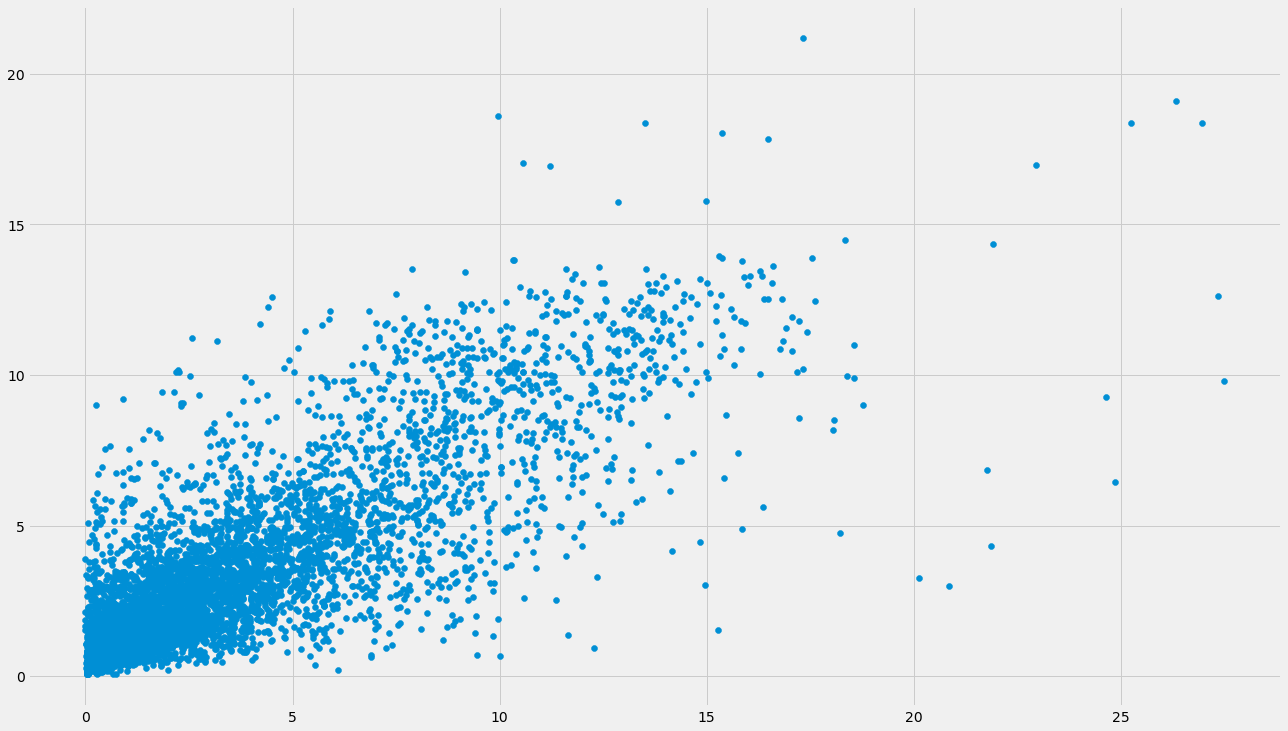

In [72]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

# Evaluate final optimized model

In [73]:
df_pred.corr()

,y_valid,y_pred
y_valid,1.000000,0.814481
y_pred,0.814481,1.000000


In [74]:
KNN.MSE(df_pred['y_valid'], df_pred['y_pred'])

2.1640849232513646

In [75]:
KNN.MAE(df_pred['y_valid'], df_pred['y_pred'])

1.3411058963274713

In [76]:
x = []
y = []
for i in range(0,100):
    i = i / 10
    x.append(i)
    y.append( sum( (df_pred['y_pred'] > df_pred['y_valid'] - i)  & (df_pred['y_pred'] < df_pred['y_valid'] + i) ) / len(df_pred) )

Text(0.5, 1.0, 'K Nearest Neighbor')

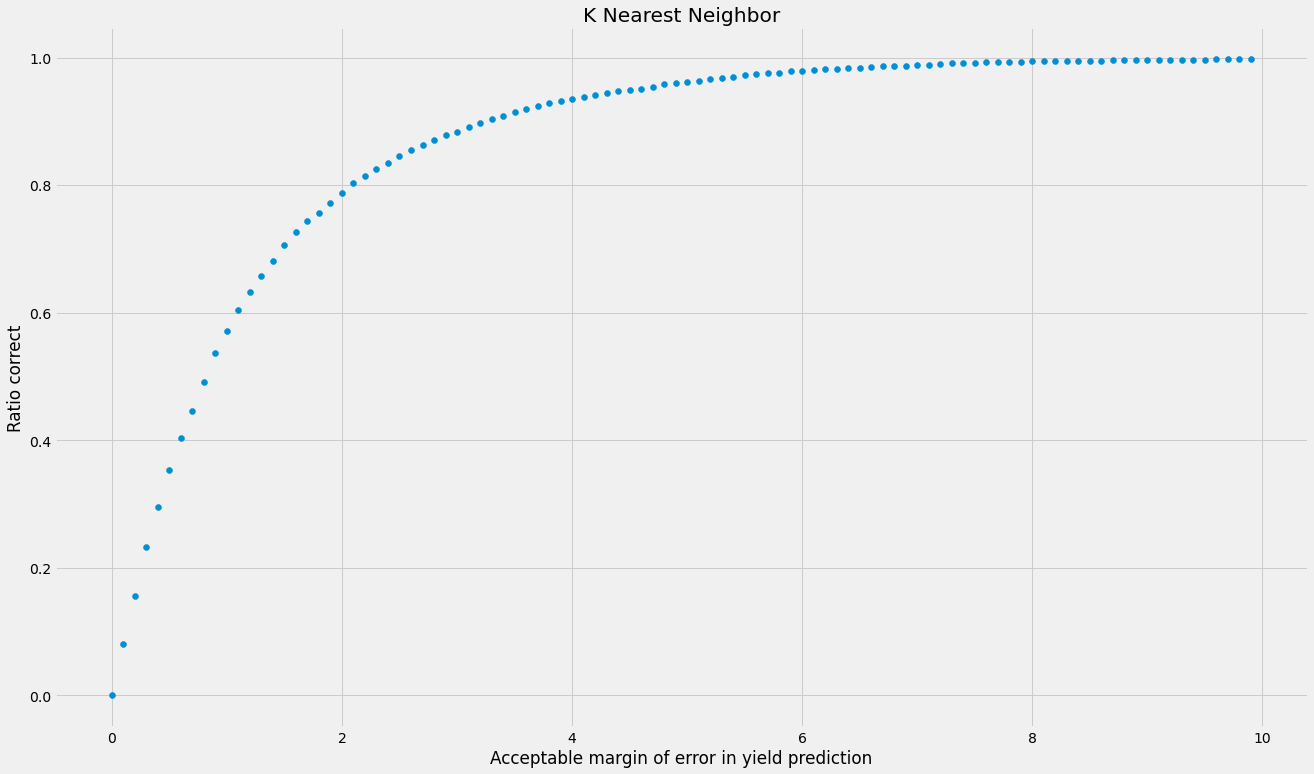

In [119]:
plt.scatter(x,y)
plt.xlabel('Acceptable margin of error in yield prediction')
plt.ylabel('Ratio correct')
plt.title('K Nearest Neighbor')

In [80]:
sum( (df_pred['y_pred'] > df_pred['y_valid'] - 2)  & (df_pred['y_pred'] < df_pred['y_valid'] + 2) ) / len(df_pred)

0.7883131201764058

In [81]:
sum( (df_pred['y_pred'] > df_pred['y_valid'] - 4)  & (df_pred['y_pred'] < df_pred['y_valid'] + 4) ) / len(df_pred)

0.9352653961253741

In [82]:
sum( (df_pred['y_pred'] > df_pred['y_valid'] - 5)  & (df_pred['y_pred'] < df_pred['y_valid'] + 5) ) / len(df_pred)

0.962041266341156

## Investigate Optimization space

Text(0.5, 1.0, ' Error vs k Hyperparameter')

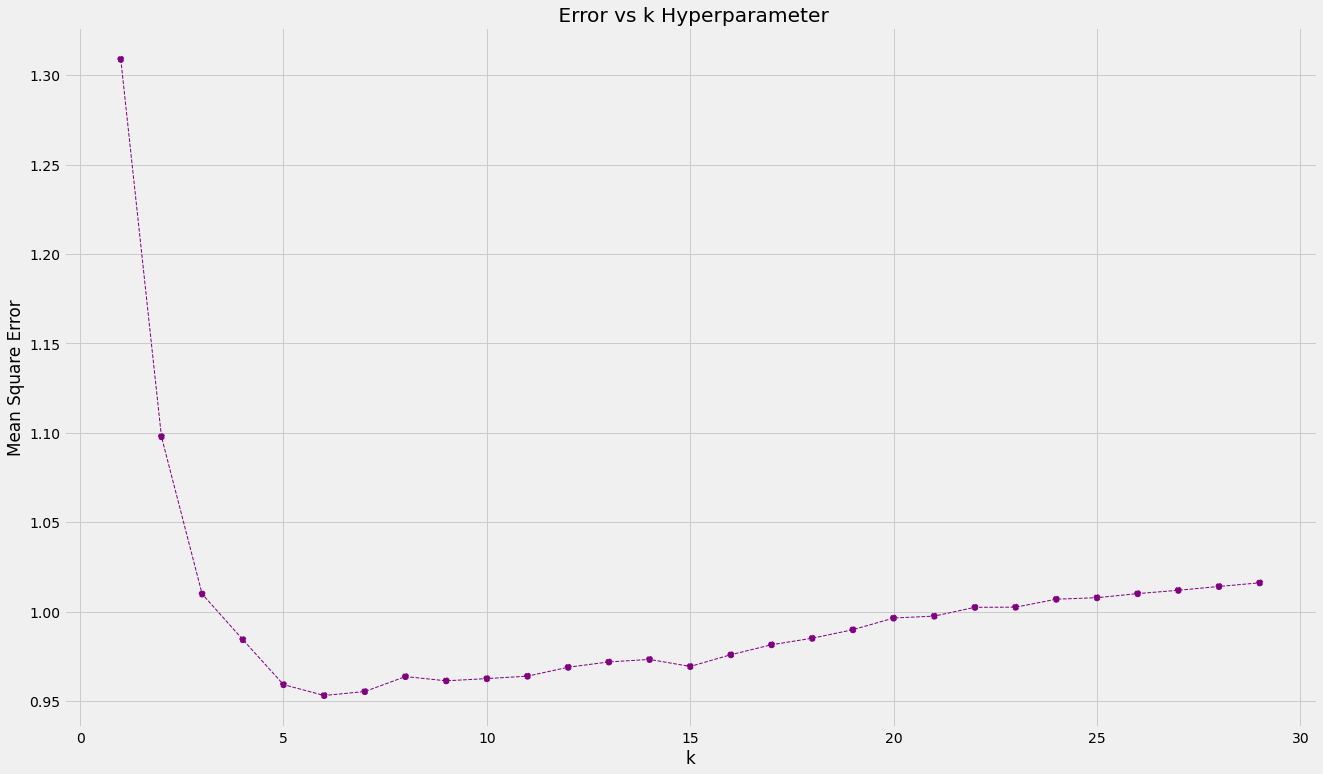

In [24]:
s = []
mse = []
for r in results:
        s.append(r['params'][0])
        mse.append(r['MSE'])

plt.plot((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('k')
plt.ylabel('Mean Square Error')
plt.title(' Error vs k Hyperparameter')

Text(0.5, 1.0, ' Runtime vs k Hyperparameter')

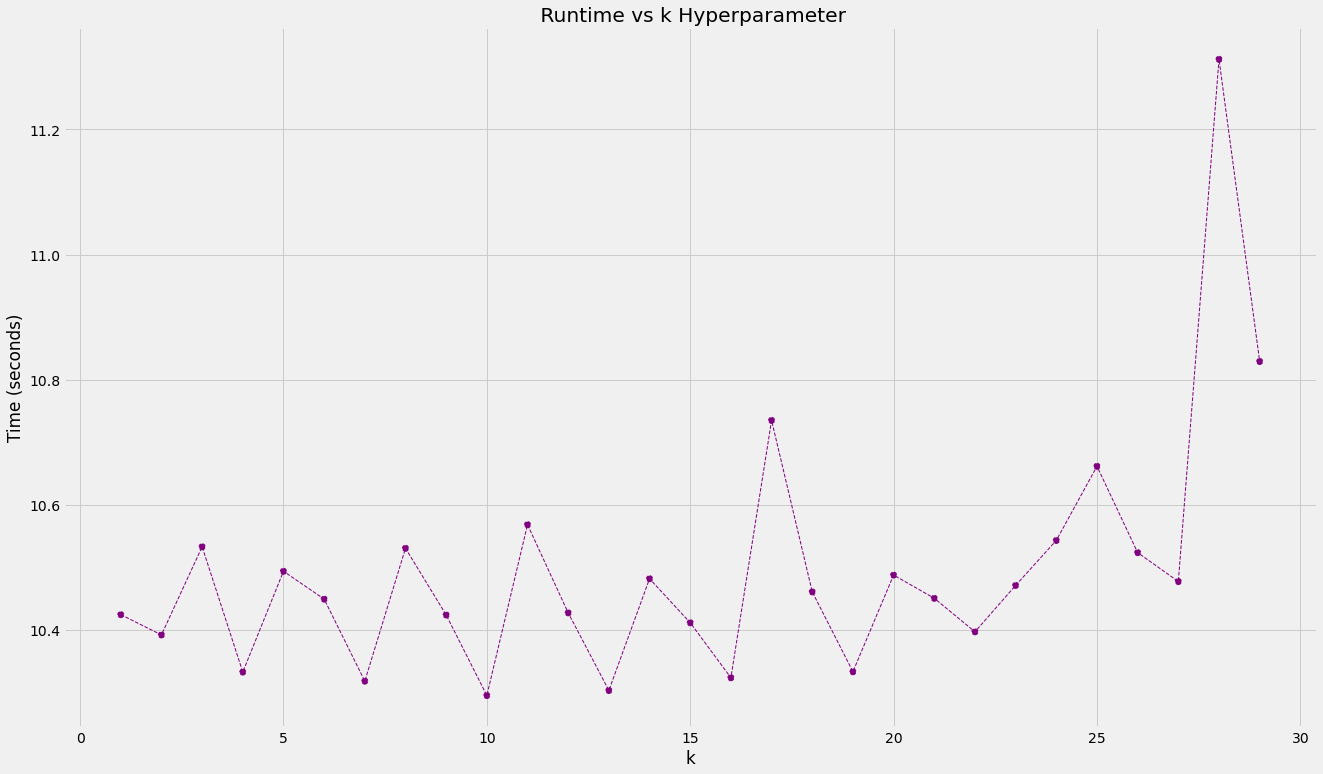

In [25]:
s = []
mse = []
for r in results:
        s.append(r['params'][0])
        mse.append(r['runtime'])

plt.plot((s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.title(' Runtime vs k Hyperparameter')

# Run model on training data to detect overfitting

In [113]:
KNN = KNearest_Neighbor(x_train, y_train, x_train, y_train, 
                                                   k = best_k)
# fit model to training data
KNN.fit(x_train,y_train)

# predict test data using model
y_pred, MSE= KNN.predict(x_train)

In [114]:
y_pred_ontrain = unnormalize(y_pred, train[1][-1],  train[2][-1])
y_train = unnormalize(y_train, train[1][-1],  train[2][-1])

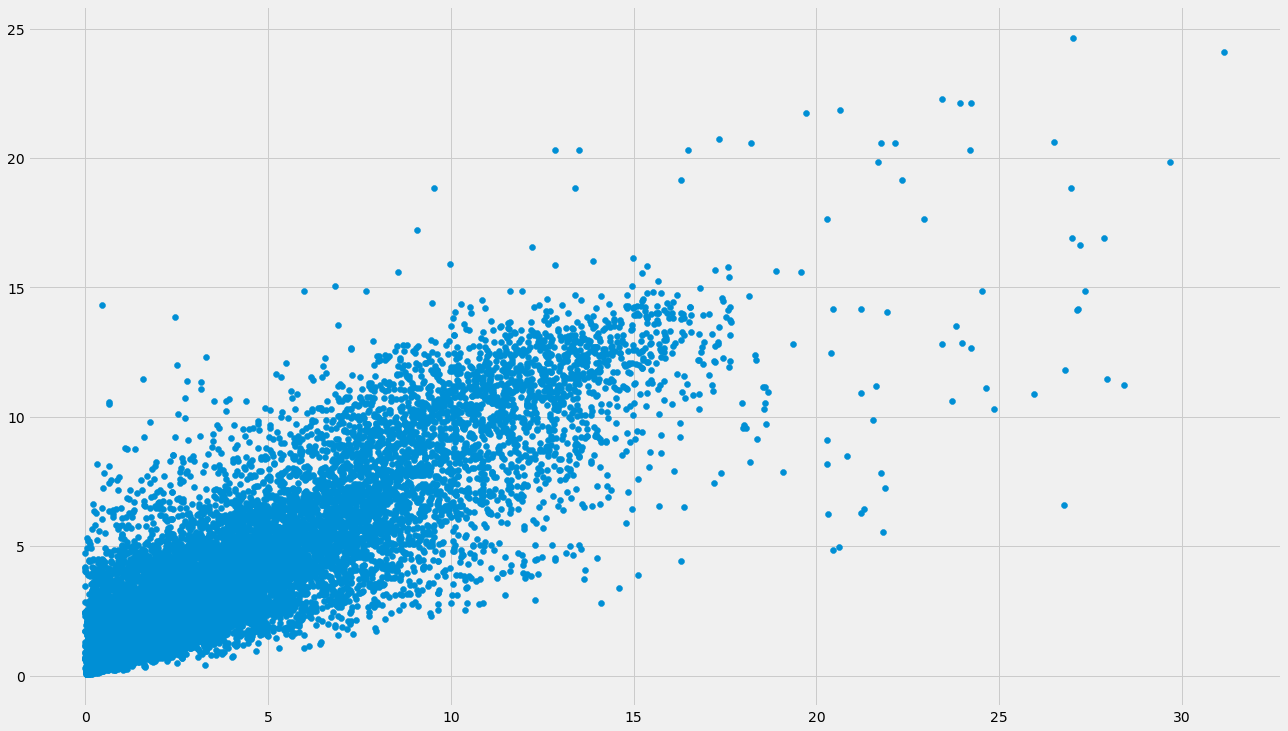

In [115]:
df_pred = pd.DataFrame(list(y_train), columns = ['y_train'])
df_pred['y_pred'] = list(y_pred_ontrain)

plt.scatter(df_pred['y_train'], df_pred['y_pred'])

In [116]:
df_pred.corr()

,y_train,y_pred
y_train,1.000000,0.873992
y_pred,0.873992,1.000000
